The data for this notebook comes from our propriety fingerspelling image collection, which per our privacy statement _**should not**_ be seen by anyone but those directly working on this project.

In [1]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf "/content/fingerspelling"
!unzip "/content/gdrive/My Drive/CS474 Final Project/CustomFingerspelling/333.zip" > /dev/null
!rmdir "/content/fingerspelling/uv"

In [0]:
root_dir = "/content/fingerspelling"

In [11]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
dataset = torchvision.datasets.ImageFolder(
          root_dir,
          transform = transforms.Compose(
              [
               transforms.RandomGrayscale(0.4),
               transforms.Resize(360), # Make it so we know where we're looking at least
               transforms.RandomResizedCrop(224, (0.5, 1)),
               transforms.RandomHorizontalFlip(),
               transforms.RandomPerspective(distortion_scale=0.2, p=0.25),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [0]:
batch_size = 20
validation_split = 0.09 # Gives roughly 26 in validation
shuffle_dataset = True
random_seed = 2019

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

z


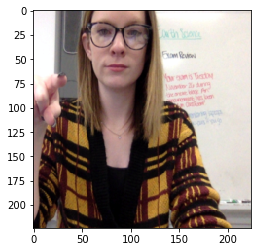

nothing


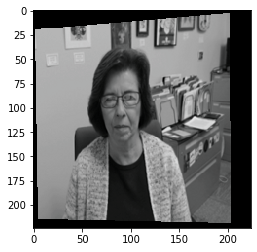

m


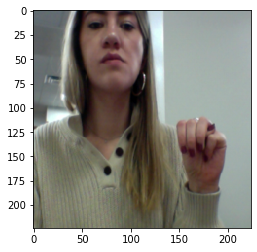

c


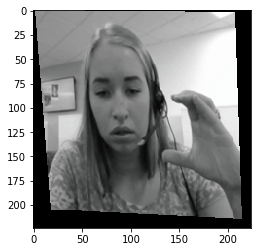

w


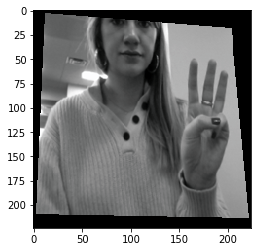

p


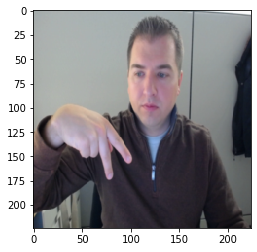

h


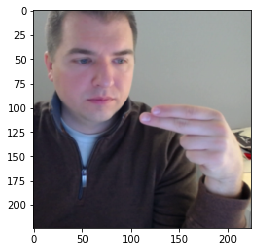

o


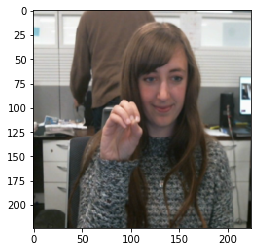

d


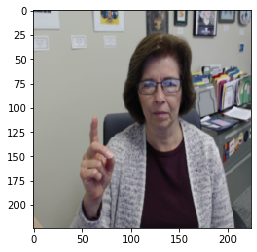

i


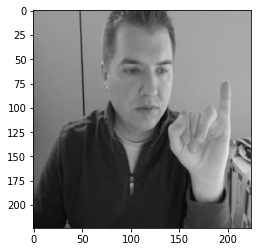

g


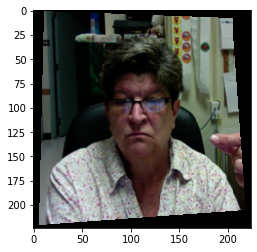

w


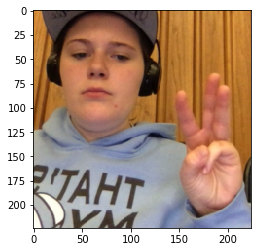

c


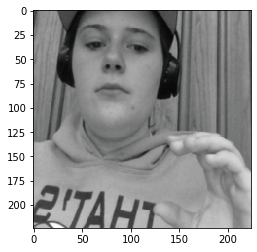

m


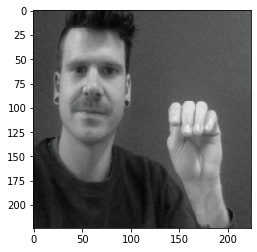

nothing


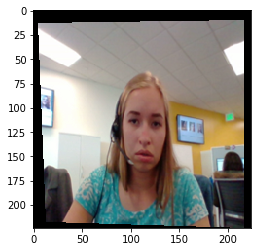

o


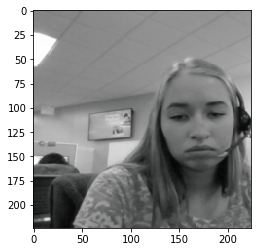

y


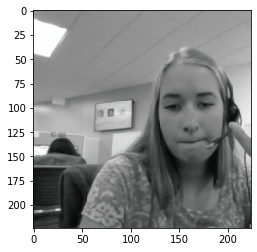

nothing


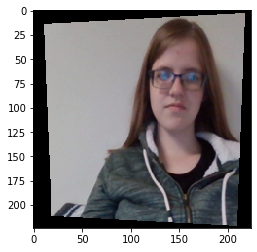

e


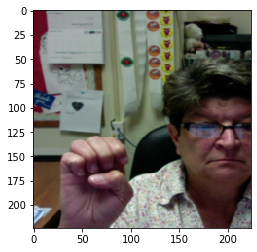

l


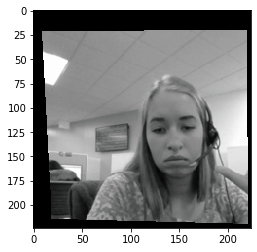

In [62]:
for x, y in train_loader:
  for i, j in zip(x, y.tolist()):
    print(dataset.classes[j])
    imshow(i)
  break

In [67]:
[dataset.classes[c] for imgs, batch in validation_loader for c in batch ]

['nothing',
 'y',
 'z',
 'a',
 'x',
 'v',
 'p',
 'k',
 'w',
 'k',
 'x',
 'n',
 's',
 'f',
 'i',
 'h',
 'nothing',
 'l',
 'n',
 't',
 'd',
 'f',
 't',
 'l',
 'y',
 'z',
 'o',
 'd',
 'a']

In [63]:
print("Number in the train sampler: {}".format(len(train_indices)))
print("Number in the validate sampler: {}".format(len(val_indices)))

Number in the train sampler: 304
Number in the validate sampler: 29


In [0]:
# Initialize Model
model = torchvision.models.resnet50(pretrained=True)
num_f = model.fc.in_features
model.fc = nn.Linear(num_f, len(dataset.classes))

model = model.cuda() #use GPU

# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [69]:
# This is what was talked about in the video for memory management
num_epochs = 100
valid_frequency = 1

best_loss = float("inf")
saved_epoch = -1

train_losses = []
validation_losses = []
train_acc = []
valid_acc = []

def scope():
  try:
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()


    loop = tqdm(
        total=(len(train_loader) * num_epochs) +
          (len(validation_loader) * (num_epochs // valid_frequency))
        , position = 0)

    for epoch in range(num_epochs):
      sum_loss = 0
      count_loss = 0

      for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x)
        y_long = y_truth.long()

        # print("\n\n-----------\ny_hat: {}, y_long: {}\n-----------\n\n".format(y_hat.size(), y_long.size()))
        loss = objective(y_hat, y_long)
        sum_loss += loss.item()
        count_loss += 1
        accuracy = 1- (torch.nonzero(torch.argmax(y_hat, 1) - y_truth).size(0) / len(y_truth))
        train_acc.append(accuracy)

        loop.set_description("epoch:{}, loss:{:.4f}, accuracy:{:.4f}".format(epoch, loss.item(), accuracy))
        loop.update(1)
        loss.backward()
        optimizer.step()

      epoch_loss = sum_loss / count_loss
      train_losses.append((epoch, epoch_loss))
      # if epoch_loss < best_loss:
        # best_loss = epoch_loss
        # saved_epoch = epoch
        # state = {
          # 'epoch': epoch,
          # 'state_dict': model.state_dict(),
          # 'optimizer': optimizer.state_dict()
        # }
        # model_file = root_dir + "224px_{:4f}loss_09percent_split.mod".format(best_loss)
        # torch.save(state, model_file)

      if epoch % valid_frequency == 0:
        sum_loss = 0
        count_loss = 0
        with torch.no_grad():
          for x, y_truth in validation_loader:
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
            y_hat = model(x)
            loss = objective(y_hat, y_truth.long())
            sum_loss += loss.item()
            count_loss += 1       
            accuracy = 1- (torch.nonzero(torch.argmax(y_hat, 1) - y_truth).size(0) / len(y_truth))
            valid_acc.append(accuracy)
          validation_losses.append((epoch, sum_loss / count_loss))
          
            # validation_accuracies.append([total_batch_counter, sum_acc / count])
          
    # Call your model, figure out loss and accuracy
    
  except:
    __ITB__()
    raise
    
scope()

epoch:99, loss:0.4348, accuracy:1.0000:  89%|████████▉ | 1600/1800 [15:07<01:26,  2.31it/s]

In [70]:
print(train_losses)
print(validation_losses)

[(0, 3.368812248110771), (1, 3.3123276829719543), (2, 3.3050524294376373), (3, 3.2739584892988205), (4, 3.2767568081617355), (5, 3.2350982427597046), (6, 3.2388421446084976), (7, 3.2027579694986343), (8, 3.193599656224251), (9, 3.1515439599752426), (10, 3.130384847521782), (11, 3.1228661239147186), (12, 3.095961421728134), (13, 3.0362805128097534), (14, 3.015235334634781), (15, 2.9593304097652435), (16, 2.9126071631908417), (17, 2.838525667786598), (18, 2.781913682818413), (19, 2.7155276089906693), (20, 2.6345745474100113), (21, 2.5946352630853653), (22, 2.5067028552293777), (23, 2.418505936861038), (24, 2.369227781891823), (25, 2.310843527317047), (26, 2.166465923190117), (27, 2.1819035708904266), (28, 2.0995346531271935), (29, 2.0099318400025368), (30, 1.9546533823013306), (31, 1.8962527588009834), (32, 1.8426276668906212), (33, 1.7813409566879272), (34, 1.8290438875555992), (35, 1.7115993797779083), (36, 1.6685155555605888), (37, 1.560226984322071), (38, 1.5371353775262833), (39, 1.

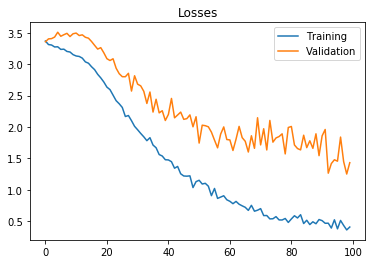

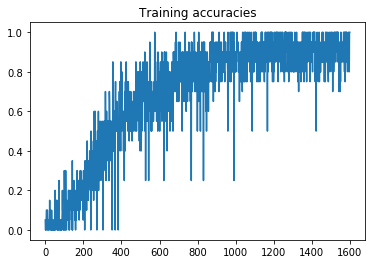

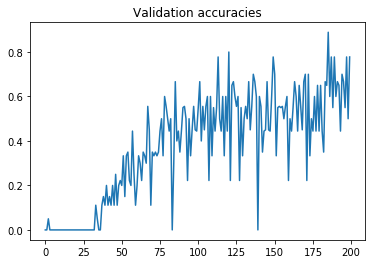

In [71]:
import matplotlib.pyplot as plt

plt.title("Losses")
plt.plot(*zip(*train_losses), label="Training")
plt.plot(*zip(*validation_losses), label="Validation")
plt.legend(loc="upper right")
plt.show()

plt.plot(train_acc)
plt.title("Training accuracies")
plt.show()

plt.plot(valid_acc)
plt.title("Validation accuracies")
plt.show()


# Validate Transfer Learning

In [0]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = "/content/gdrive/My Drive/models/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_file = root_dir + "transfer_learning_done.mod"
loaded = torch.load(model_file)
# print(loaded)
model.load_state_dict(loaded)


<All keys matched successfully>

In [0]:
model = ConvNetwork(3, len(dataset.dataset_folder.classes), dimensions=128).cuda()
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [72]:
# !cd "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/" && unzip Photos.zip
!#mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle"
#!mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

!ls "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

IMG_20191109_203810.jpg  IMG_20191109_203816.jpg  IMG_20191109_203822.jpg
IMG_20191109_203812.jpg  IMG_20191109_203818.jpg  IMG_20191109_203824.jpg
IMG_20191109_203814.jpg  IMG_20191109_203819.jpg


In [0]:
# michelle_set = ASLDataset("/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet", "Michelle", size=224)
michelle_set = torchvision.datasets.ImageFolder(
          "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle",
          transform = transforms.Compose(
              [
               transforms.Resize(224), # Make it so we know where we're looking at least
              #  transforms.RandomResizedCrop(224, (0.8, 1)),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

michelle_loader = DataLoader(michelle_set, batch_size=10)

In [115]:
print(len(michelle_set))
print(len(michelle_loader))

8
1


In [116]:
michelle_set.classes

['name']

In [117]:
batches = [model(i.cuda()) for i, j in michelle_loader]
"".join([dataset.classes[torch.argmax(item)] for batch in batches for item in batch])

'eichelly'

tensor([20,  8,  2,  7,  4, 11, 11,  4], device='cuda:0')
Actual: a Guess: t


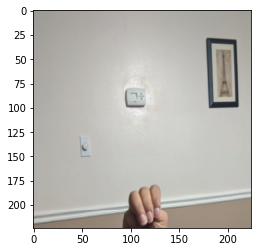

Actual: a Guess: i


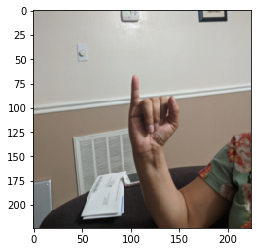

Actual: a Guess: c


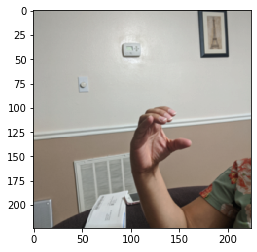

Actual: a Guess: h


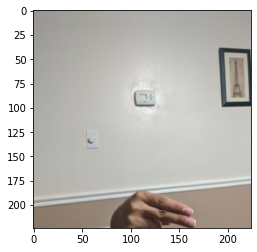

Actual: a Guess: e


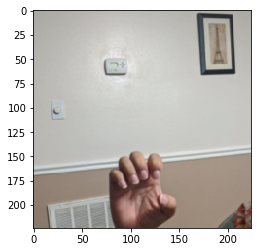

Actual: a Guess: l


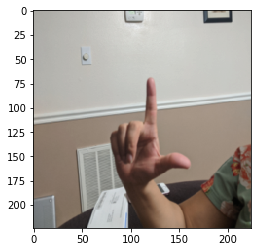

Actual: a Guess: l


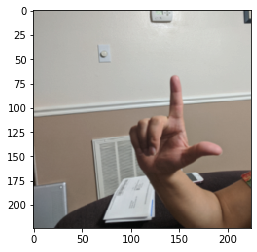

Actual: a Guess: e


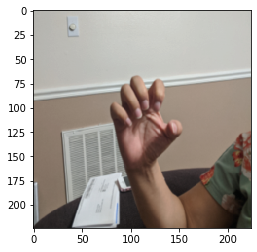

In [86]:
sum = 0
for i, j in michelle_loader:
  sum += 1
  res = model(i.cuda())
  chosen = torch.argmax(res, dim=1)
  print(chosen)
  actual = [dataset.classes[a] for a in j.tolist()]
  solved = [dataset.classes[a] for a in chosen.tolist()]
  for c, v in enumerate(zip(actual, solved)):
    a, s = v
    print("Actual: {} Guess: {}".format(a, s))
    try:
      imshow(i[c])
    except:
      pass

  if sum > 0:
    break

tensor([ 1, 22, 10, 13,  6,  5, 15, 18,  3, 10,  3, 12, 25, 11, 17, 23,  8, 28,
        23,  5,  0,  6, 25, 10, 15, 12, 15, 18, 11,  0,  3,  4, 17,  0, 22, 22,
         2, 22, 25,  9, 26, 13,  3, 26, 28,  8, 19, 26, 23, 12, 15, 10,  4, 13,
        22, 23,  9,  3, 19, 24,  2, 25,  5, 27, 10, 10,  9, 10, 25,  9, 22,  9,
        28,  3, 12, 27, 21,  1, 27, 19, 10, 10,  3,  8, 17,  4,  6, 10, 27,  0,
        16, 16,  1,  9,  2, 18, 19,  6, 22, 12,  3, 26, 13, 26,  1, 22,  9, 16,
        18,  5,  0, 11, 23,  3, 18, 26, 19, 13, 16, 27,  9, 19, 11,  9, 21,  8,
        14, 13], device='cuda:0')
Actual: B Guess: B


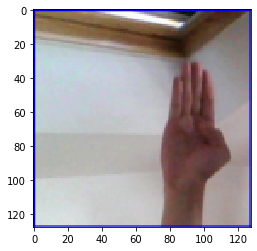

Actual: X Guess: W


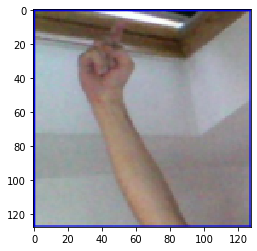

Actual: K Guess: K


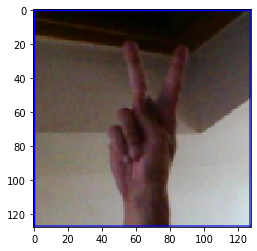

Actual: M Guess: N


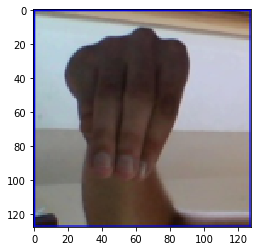

Actual: G Guess: G


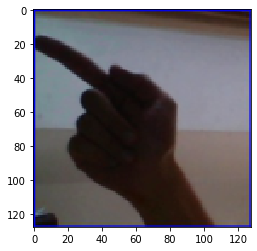

Actual: A Guess: F


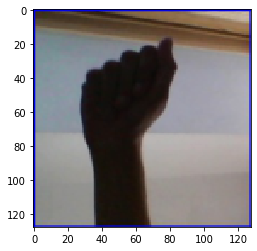

Actual: P Guess: P


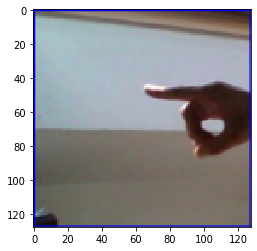

Actual: S Guess: S


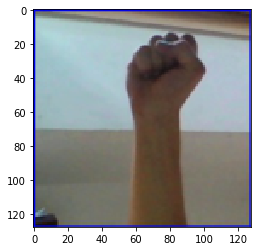

Actual: O Guess: D


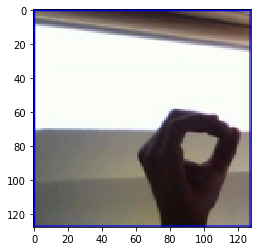

Actual: K Guess: K


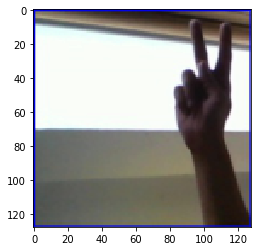

Actual: A Guess: D


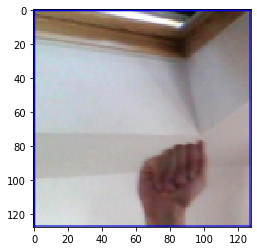

Actual: M Guess: M


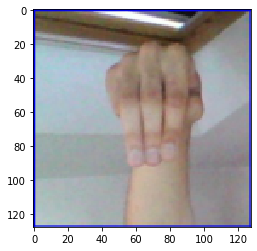

Actual: Z Guess: Z


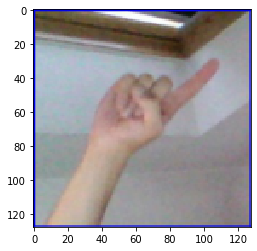

Actual: C Guess: L


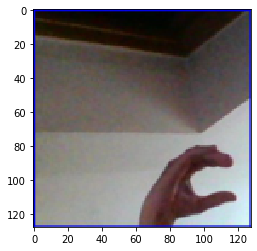

Actual: E Guess: R


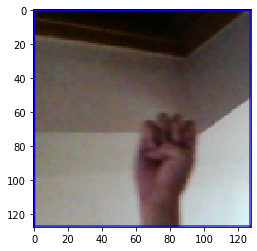

Actual: O Guess: X


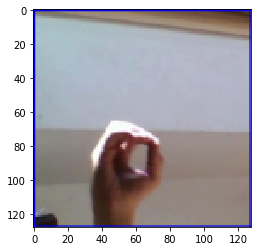

Actual: I Guess: I


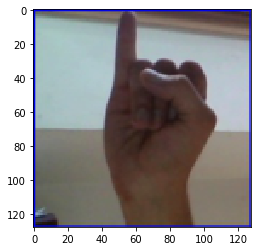

Actual: space Guess: space


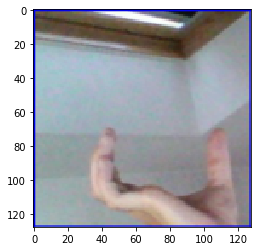

Actual: X Guess: X


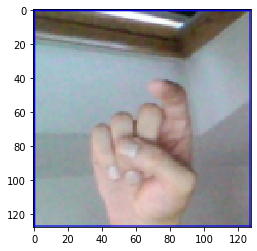

Actual: F Guess: F


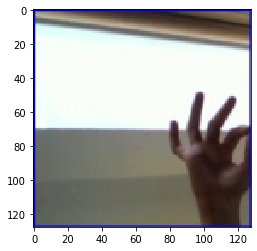

Actual: A Guess: A


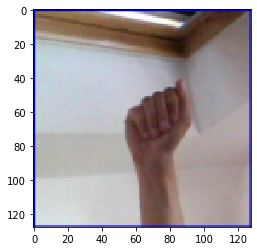

Actual: G Guess: G


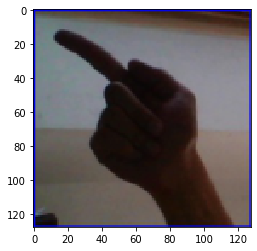

Actual: Z Guess: Z


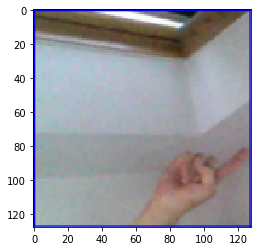

Actual: K Guess: K


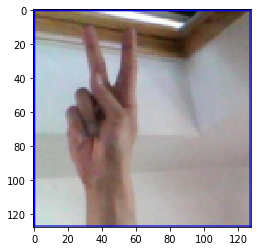

Actual: P Guess: P


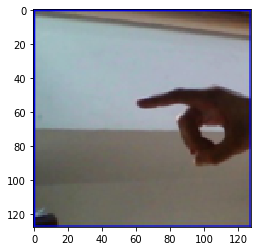

Actual: N Guess: M


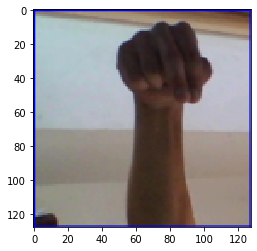

Actual: P Guess: P


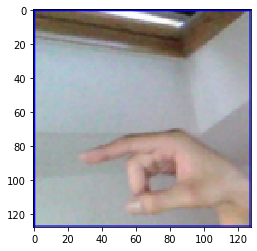

Actual: S Guess: S


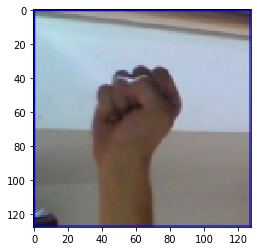

Actual: L Guess: L


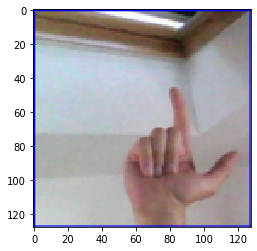

Actual: A Guess: A


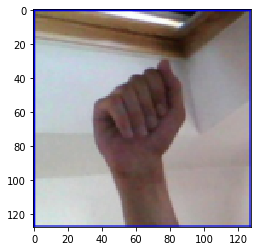

Actual: B Guess: D


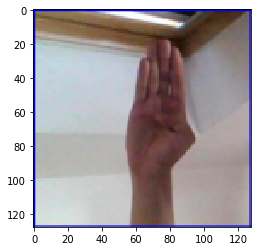

Actual: W Guess: E


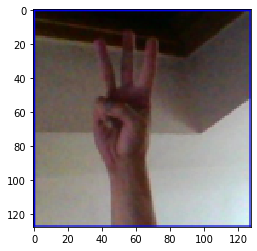

Actual: O Guess: R


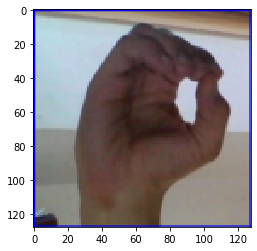

Actual: T Guess: A


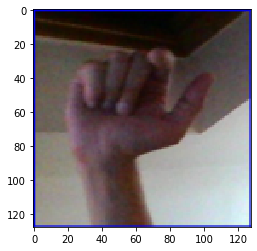

Actual: W Guess: W


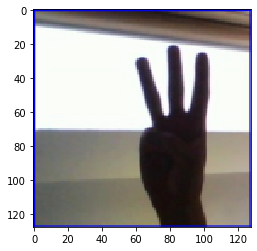

Actual: X Guess: W


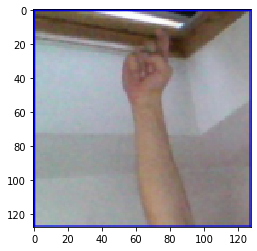

Actual: C Guess: C


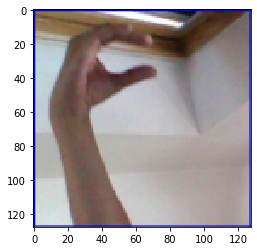

Actual: W Guess: W


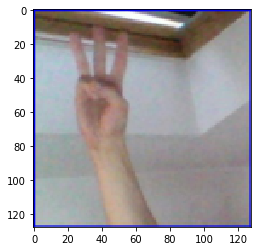

Actual: X Guess: Z


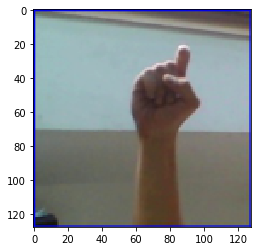

Actual: J Guess: J


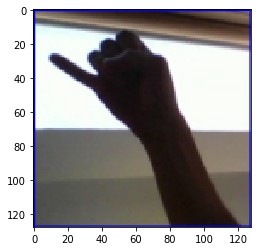

Actual: T Guess: del


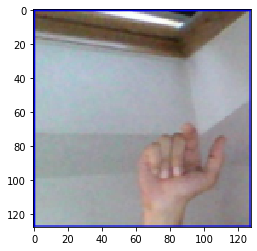

Actual: N Guess: N


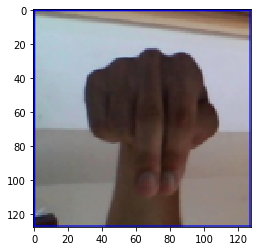

Actual: D Guess: D


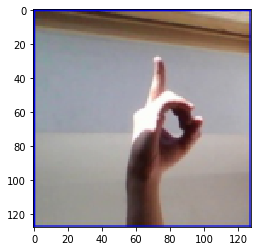

Actual: del Guess: del


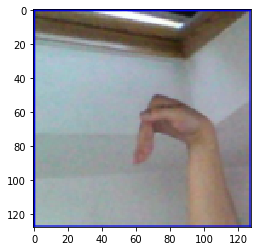

Actual: U Guess: space


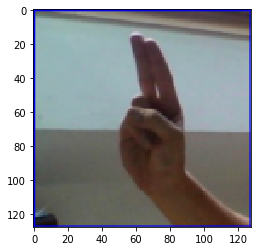

Actual: I Guess: I


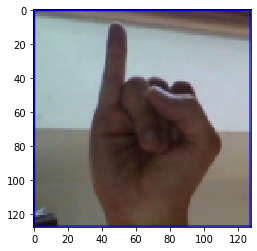

Actual: T Guess: T


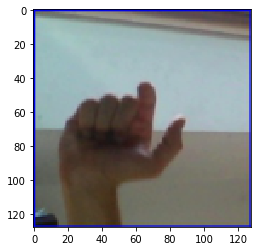

Actual: del Guess: del


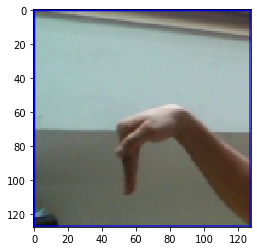

Actual: X Guess: X


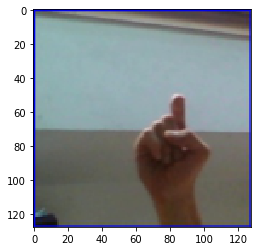

Actual: N Guess: M


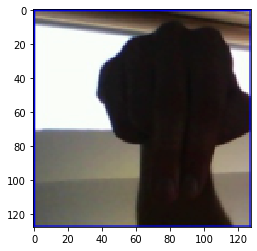

Actual: P Guess: P


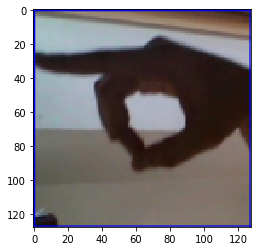

Actual: K Guess: K


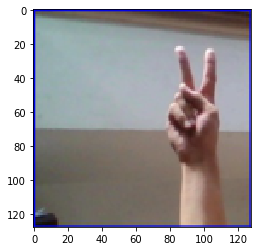

Actual: D Guess: E


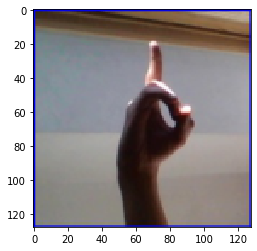

Actual: L Guess: N


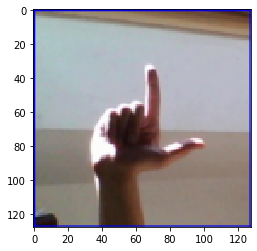

Actual: W Guess: W


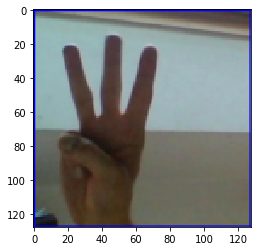

Actual: X Guess: X


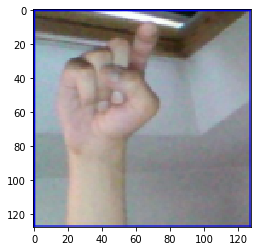

Actual: V Guess: J


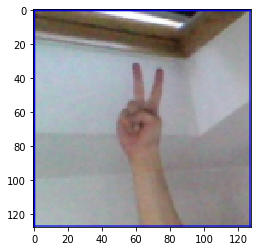

Actual: D Guess: D


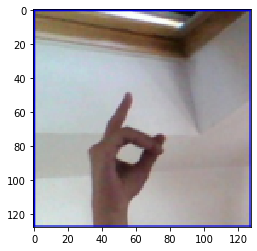

Actual: T Guess: T


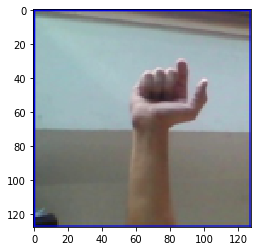

Actual: Y Guess: Y


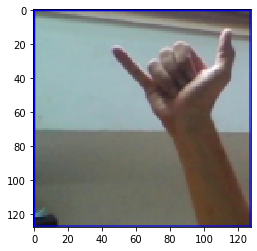

Actual: C Guess: C


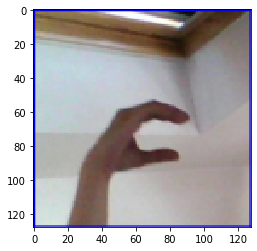

Actual: Z Guess: Z


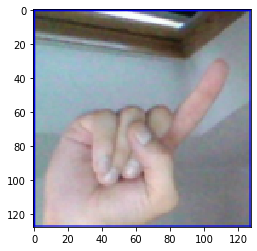

Actual: E Guess: F


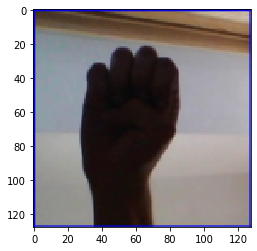

Actual: A Guess: nothing


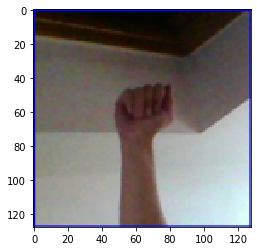

Actual: K Guess: K


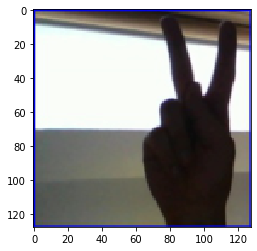

Actual: K Guess: K


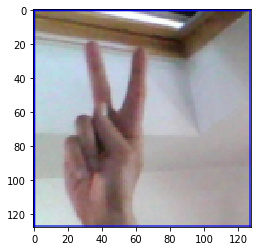

Actual: J Guess: J


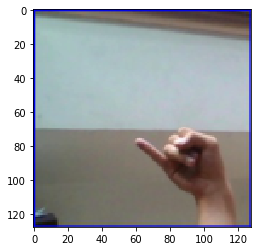

Actual: K Guess: K


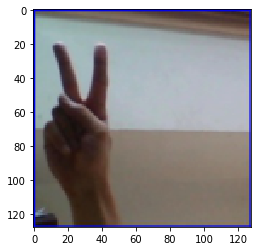

Actual: Z Guess: Z


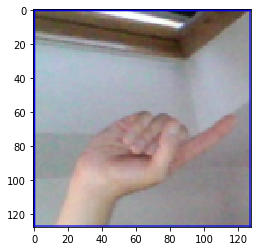

Actual: Z Guess: J


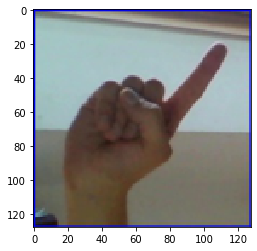

Actual: W Guess: W


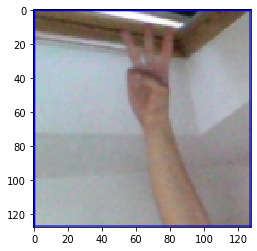

Actual: J Guess: J


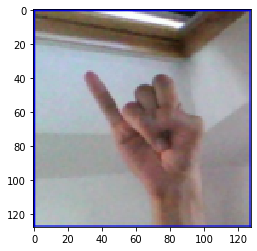

Actual: Y Guess: space


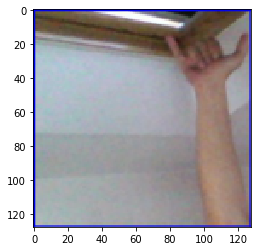

Actual: D Guess: D


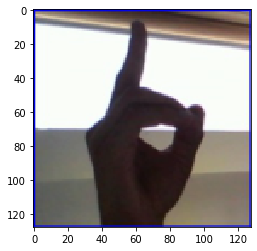

Actual: M Guess: M


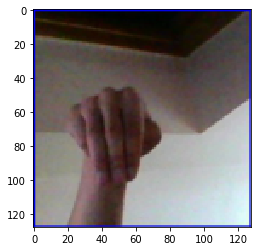

Actual: nothing Guess: nothing


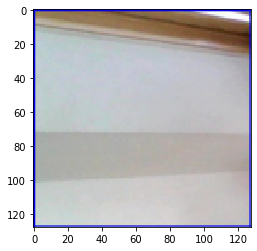

Actual: V Guess: V


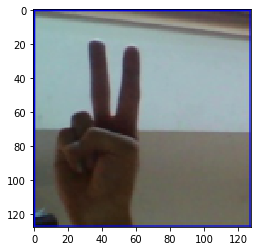

Actual: A Guess: B


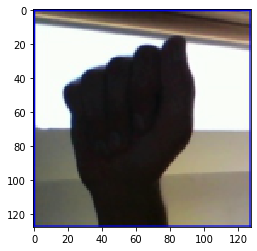

Actual: nothing Guess: nothing


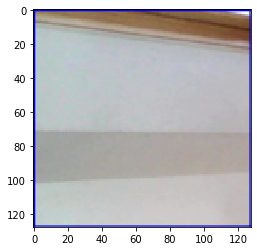

Actual: T Guess: T


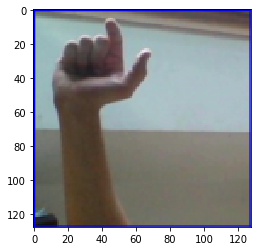

Actual: K Guess: K


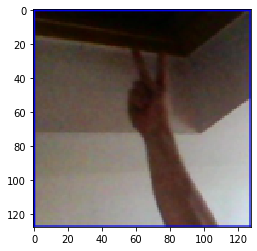

Actual: L Guess: K


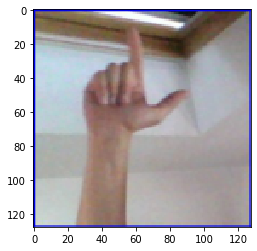

Actual: D Guess: D


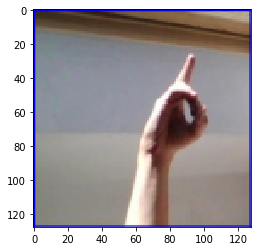

Actual: F Guess: I


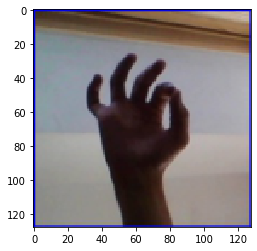

Actual: R Guess: R


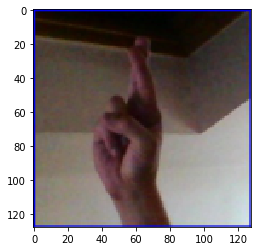

Actual: A Guess: E


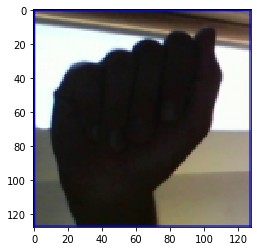

Actual: D Guess: G


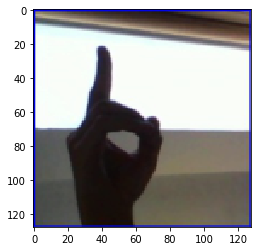

Actual: K Guess: K


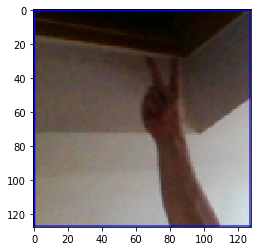

Actual: nothing Guess: nothing


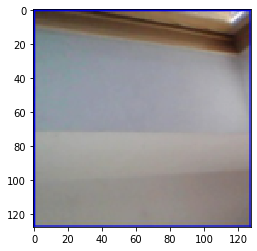

Actual: A Guess: A


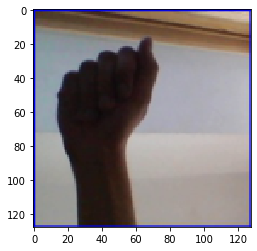

Actual: Q Guess: Q


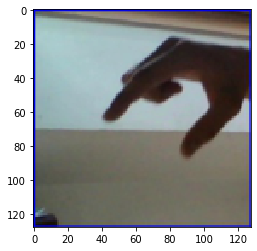

Actual: del Guess: Q


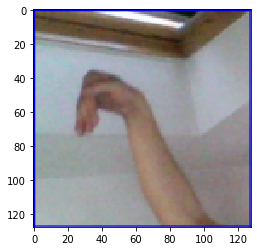

Actual: B Guess: B


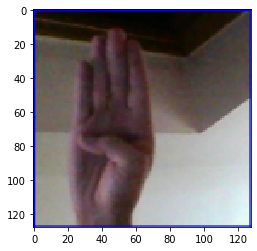

Actual: U Guess: J


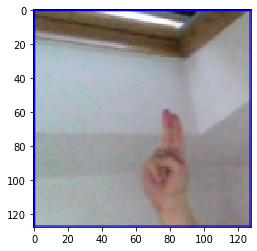

Actual: G Guess: C


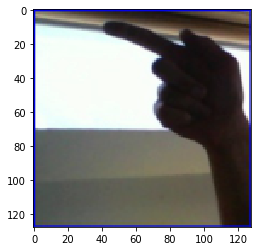

Actual: S Guess: S


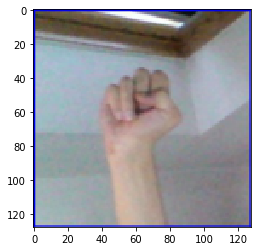

Actual: Y Guess: T


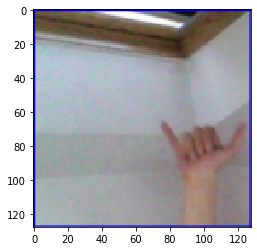

Actual: G Guess: G


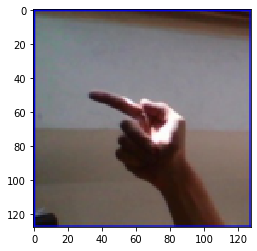

Actual: W Guess: W


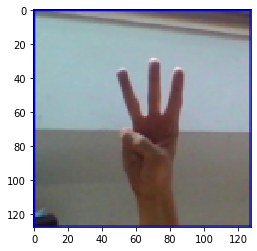

Actual: U Guess: M


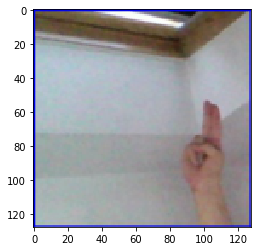

Actual: D Guess: D


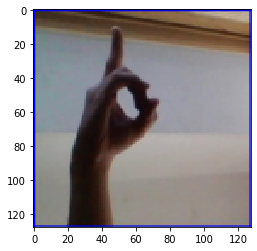

Actual: del Guess: del


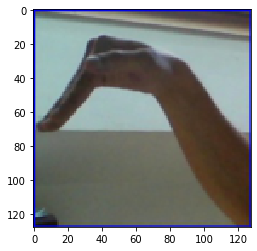

Actual: N Guess: N


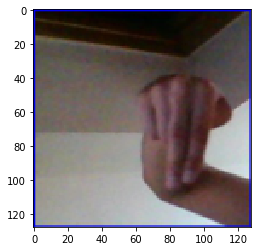

Actual: del Guess: del


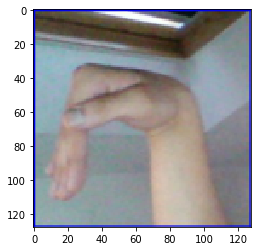

Actual: B Guess: B


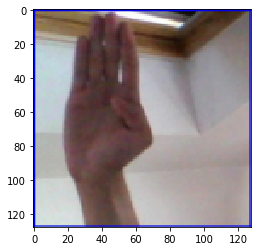

Actual: W Guess: W


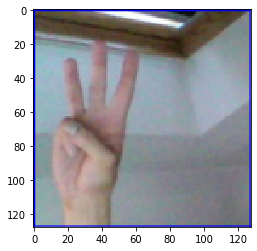

Actual: S Guess: J


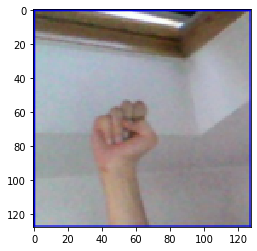

Actual: Q Guess: Q


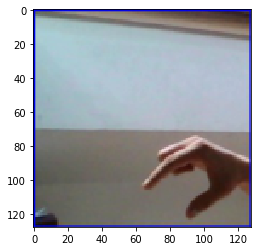

Actual: S Guess: S


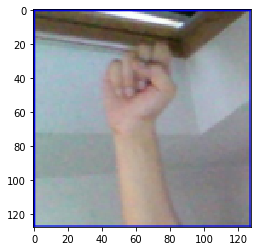

Actual: O Guess: F


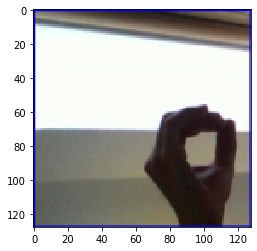

Actual: A Guess: A


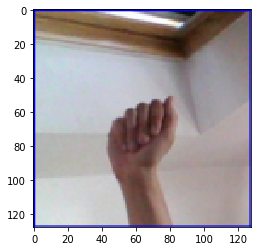

Actual: L Guess: L


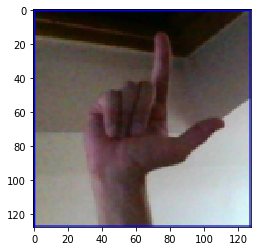

Actual: X Guess: X


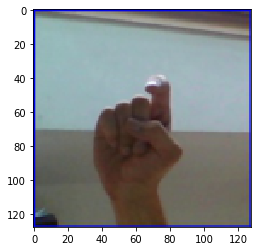

Actual: D Guess: D


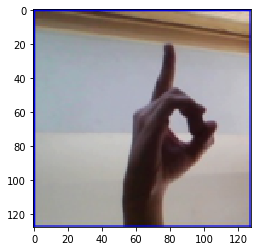

Actual: S Guess: S


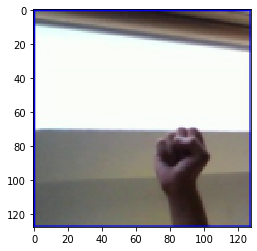

Actual: del Guess: del


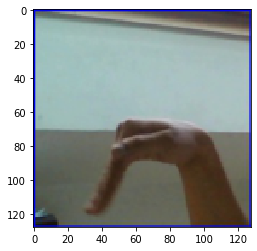

Actual: T Guess: T


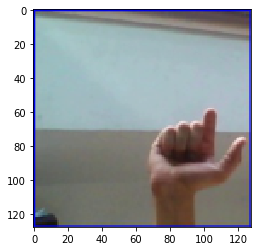

Actual: M Guess: N


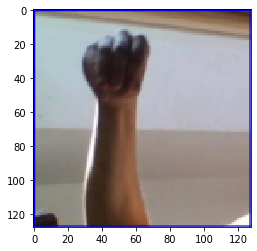

Actual: Q Guess: Q


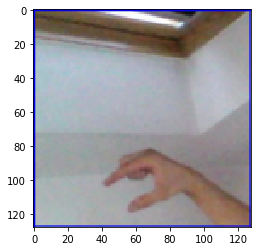

Actual: nothing Guess: nothing


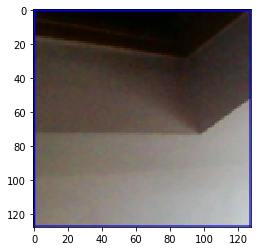

Actual: J Guess: J


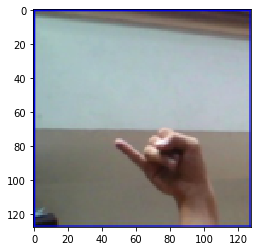

Actual: T Guess: T


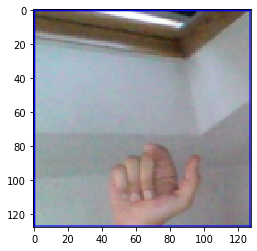

Actual: L Guess: L


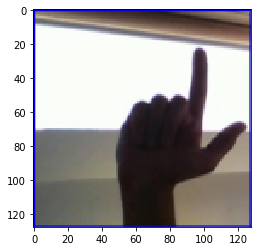

Actual: J Guess: J


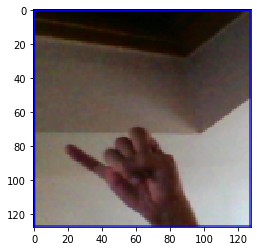

Actual: Z Guess: V


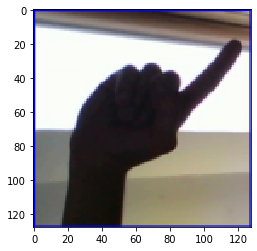

Actual: Z Guess: I


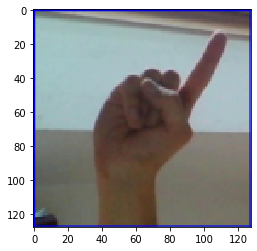

Actual: R Guess: O


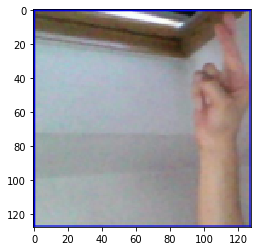

Actual: D Guess: N


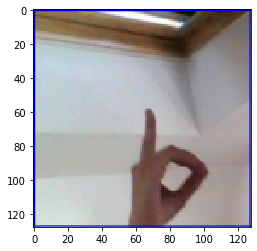

In [0]:
sum = 0
for i, j in validation_loader:
  sum += 1
  res = model(i.cuda())
  chosen = torch.argmax(res, dim=1)
  print(chosen)
  actual = [dataset.dataset_folder.classes[a] for a in j.tolist()]
  solved = [dataset.dataset_folder.classes[a] for a in chosen.tolist()]
  for c, v in enumerate(zip(actual, solved)):
    a, s = v
    print("Actual: {} Guess: {}".format(a, s))
    try:
      imshow(i[c])
    except:
      pass

  if sum > 0:
    break

In [0]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [0]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

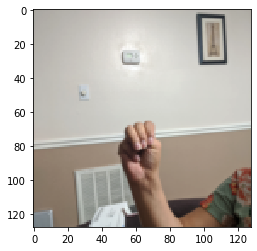

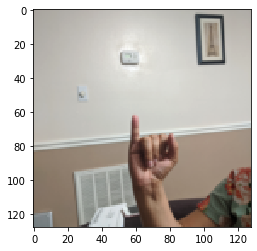

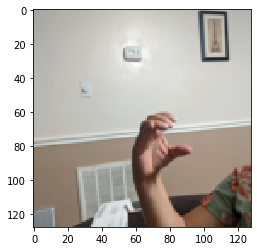

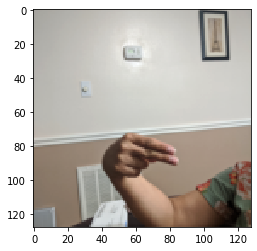

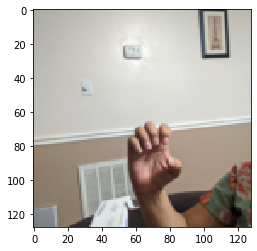

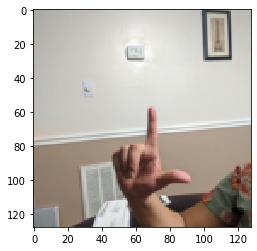

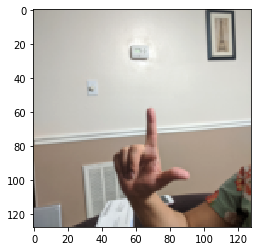

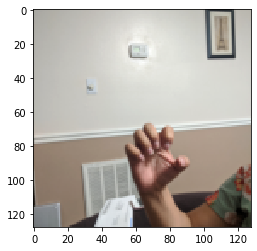

In [0]:
for x, y in michelle_loader:
  show_imgs(x)


# SSH Access

If ssh_connect is True, an ssh server will be set up on the hosting server. Ergo power.

In [0]:
ssh_connect = False
if ssh_connect:
  import random, string, getpass

  password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))
  alias = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8))
  ! echo root:$password | chpasswd

  ! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
  ! mkdir -p /var/run/sshd
  ! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config && echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
  ! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc && echo "export LD_LIBRARY_PATH" >> /root/.bashrc
  get_ipython().system_raw('/usr/sbin/sshd -D &')

  print('sshpass -p {} ssh -o "StrictHostKeyChecking no" -J serveo.net root@{}'.format(password, alias))
  ! ssh -o "StrictHostKeyChecking no" -R $alias:22:localhost:22 serveo.net